<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Final/Grid_Test_Knock_In_Call_1stock_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 8)
B_range = jnp.linspace(1.1, 1.6, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)

print(S_range)
print(K_range)
print(B_range)
print(sigma_range)
print(r_range)

[0.75       0.8055556  0.86111116 0.9166666  0.97222227 1.0277778
 1.0833334  1.138889   1.1944445  1.25      ]
[0.75       0.82142854 0.89285713 0.9642857  1.0357143  1.1071429
 1.1785713  1.25      ]
[1.1       1.1714286 1.2428572 1.3142858 1.3857143 1.4571428 1.5285715
 1.6      ]
[0.15       0.25       0.35000002 0.45      ]
[0.01  0.025 0.04 ]


In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_in_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_in_index]/(knock_in_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_in_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_in_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 8)
B_range = jnp.linspace(1.1, 1.6, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)
T = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
####################################################################

call = []
count = 0

for S in S_range:
  for K in K_range:
    for B in B_range:
      for r in r_range:
        for sigma in sigma_range:    

          initial_stocks = jnp.array([S]*numstocks) # must be float
          r_tmp = jnp.array([r]*numsteps)
          drift = jnp.array([r]*numstocks)
          cov = jnp.identity(numstocks)*sigma*sigma

          Knock_In_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T,numpaths)
          Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T,numpaths)
          call.append([T, K, B, S, sigma, r, r, Knock_In_Call_price] + list(Deltas)) #T, K, B, S, sigma, mu, r, price, delta
          
          count += 1
          print(count)

In [ ]:
# Thedataset = pd.DataFrame(call)
# #T, K, B, S, sigma, r, r
# Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,1.1,0.75,0.15,0.010,0.010,0.003048922,0.012453
1,1.0,0.75,1.1,0.75,0.25,0.010,0.010,0.034801595,0.139740
2,1.0,0.75,1.1,0.75,0.35,0.010,0.010,0.07676853,0.303222
3,1.0,0.75,1.1,0.75,0.45,0.010,0.010,0.112610094,0.437808
4,1.0,0.75,1.1,0.75,0.15,0.025,0.025,0.0039772727,0.016244
...,...,...,...,...,...,...,...,...,...
7675,1.0,1.25,1.6,1.25,0.45,0.025,0.025,0.1938404,0.627148
7676,1.0,1.25,1.6,1.25,0.15,0.040,0.040,0.043076728,0.150861
7677,1.0,1.25,1.6,1.25,0.25,0.040,0.040,0.113577545,0.386973
7678,1.0,1.25,1.6,1.25,0.35,0.040,0.040,0.163221,0.541586


In [ ]:
# # save to csv
# Thedataset.to_csv('Knock_In_Call_1stock_MC_Datset_v2.csv', index=False, header=False)

In [ ]:
# read csv
import pandas as pd
#T, K, B, S, sigma, r, r
Thedataset = pd.read_csv('Knock_In_Call_1stock_MC_Datset_v3.csv', header=None)
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,1.1,0.75,0.15,0.010,0.010,0.003040,0.012413
1,1.0,0.75,1.1,0.75,0.25,0.010,0.010,0.034446,0.138302
2,1.0,0.75,1.1,0.75,0.35,0.010,0.010,0.076174,0.300842
3,1.0,0.75,1.1,0.75,0.45,0.010,0.010,0.111995,0.435450
4,1.0,0.75,1.1,0.75,0.15,0.025,0.025,0.003885,0.015867
...,...,...,...,...,...,...,...,...,...
7675,1.0,1.25,1.6,1.25,0.45,0.025,0.025,0.192026,0.621270
7676,1.0,1.25,1.6,1.25,0.15,0.040,0.040,0.041765,0.146246
7677,1.0,1.25,1.6,1.25,0.25,0.040,0.040,0.111081,0.378544
7678,1.0,1.25,1.6,1.25,0.35,0.040,0.040,0.160237,0.531738


# Construct Neural Net

In [ ]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:7]
Thedataset_Y = Thedataset.iloc[:,7:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
ds = OptionDataSet(max_len = 1)
for i in ds:
    print(i[0])
    print(i[0].shape)
    print(i[1])
    print(i[1].shape)

tensor([[1.000000, 0.750000, 1.100000,  ..., 0.150000, 0.010000, 0.010000],
        [1.000000, 0.750000, 1.100000,  ..., 0.250000, 0.010000, 0.010000],
        [1.000000, 0.750000, 1.100000,  ..., 0.350000, 0.010000, 0.010000],
        ...,
        [1.000000, 1.250000, 1.600000,  ..., 0.250000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.600000,  ..., 0.350000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.600000,  ..., 0.450000, 0.040000, 0.040000]],
       device='cuda:0', dtype=torch.float64)
torch.Size([7680, 7])
tensor([[0.003040, 0.012413],
        [0.034446, 0.138302],
        [0.076174, 0.300842],
        ...,
        [0.111081, 0.378544],
        [0.160237, 0.531738],
        [0.195411, 0.632132]], device='cuda:0', dtype=torch.float64)
torch.Size([7680, 2])


In [12]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*1, 64) # remember to change this!
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2) # 2 outputs: price, delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03]*1)) # don't use numpy here - will give error later
                                                                               # T, K, B, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.6, 0.75, 0.15, 0.01, 0.01]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


# Train Neural Net

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 7.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 200) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y_pred.shape)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 500)

model_save_name = 'jax_knock_in_1stock_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  if __name__ == '__main__':


loss 0.06658700726068745 average time 0.007368923750050271 iter num 20
loss 0.049778478345650176 average time 0.005403495175016815 iter num 40
loss 0.037973097845150676 average time 0.00464177248334939 iter num 60
loss 0.026284066495620248 average time 0.004395842087512846 iter num 80
loss 0.01650091816421112 average time 0.004203251870017084 iter num 100
loss 0.011220816755710484 average time 0.0040517326583464335 iter num 120
loss 0.009250286818512896 average time 0.003913023957157488 iter num 140
loss 0.008588905722466216 average time 0.0038085610687659255 iter num 160
loss 0.008377090269258746 average time 0.0037367597833533888 iter num 180
loss 0.008323716421979538 average time 0.0036647038400178644 iter num 200
loss 0.007241968193054832 average time 0.0031620086999737396 iter num 20
loss 0.007026215091883093 average time 0.0030717292999611345 iter num 40
loss 0.0068980222045327885 average time 0.0030341444833159887 iter num 60
loss 0.00681012600821356 average time 0.0030183189749

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_knock_in_1stock_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import torch
model_save_name = 'jax_knock_in_1stock_oldmethod_1.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [15]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=2, bias=True)
)


#Results

In [ ]:
# Knock in call
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_in_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_in_index]/(knock_in_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_in_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_in_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

K = 1.0
T = 1.0
r = 0.02
sigma = 0.25
B = 1.3
initial_stocks = jnp.array([1.0]*numstocks) # must be float
r_tmp = jnp.array([r]*numsteps)
drift = jnp.array([r]*numstocks)
cov = jnp.identity(numstocks)*sigma*sigma

fast_simple = jax.jit(Brownian_motion, static_argnums=2)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
# print(optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T,numpaths)) # here numsteps different from T

# delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T,numpaths)) # here numsteps different from T

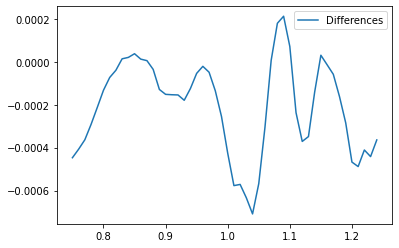

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compute_price(S):
    inputs = torch.tensor([[1, 1, 1.3, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][0]

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
correct_call_prices = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_prices.append(compute_price(p).item())
    correct_call_prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T,numpaths))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, correct_call_prices, label = "correct_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(correct_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

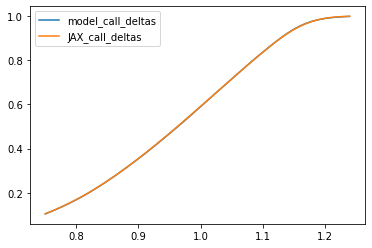

In [ ]:
##Using gradient, Change only 1 S0 at a time
B = 1.1
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
B = 1.15
def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, B, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, 1.0, B, T,numpaths))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

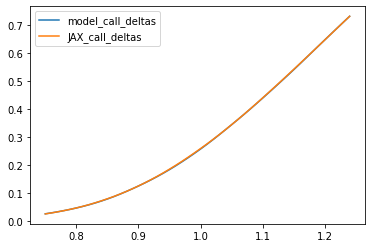

In [ ]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.35
def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, B, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, 0.775, B, T,numpaths))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

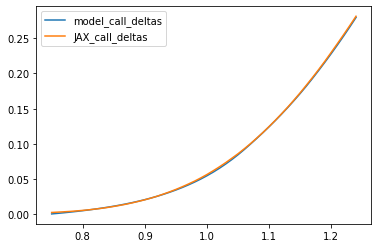

In [ ]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

B = 1.65
def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, B, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, 1.225, B, T,numpaths))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas,   label = "JAX_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

# Comparison on speed

In [ ]:
# time difference for computing delta
%timeit goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T, numpaths)
%timeit compute_delta(1).item()

10 loops, best of 5: 362 ms per loop
The slowest run took 800.27 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 343 µs per loop


# Heat Map

In [20]:
import pandas as pd
import numpy as np
import cupy

df = pd.DataFrame(np.zeros((25,10)))
df.columns = np.around(np.linspace(0.005, 0.05, 10), 3)
df.index = np.around(np.arange(0.77, 1.27, 0.02), 2)

for col_num,approx_width in enumerate(df.columns):
  base = []
  approx = [] # approximated value calculated from base
  model_value = [] # value given by model
  for S in df.index:
    inputs = torch.tensor([[1, 1, 1.15, S - approx_width, 0.25, 0.02, 0.02]]).cuda()
    base.append(model(inputs.float())[0][0])
    approx.append(model(inputs.float())[0][0] + ((model(inputs.float())[0][1:]) * approx_width).sum())
    inputs2 = torch.tensor([[1, 1, 1.15, S, 0.25, 0.02, 0.02]]).cuda()
    model_value.append(model(inputs2.float())[0][0])
  abs_error = (np.absolute(np.array(approx)-np.array(model_value))).astype(float)
  df.iloc[:,col_num] = abs_error

df

,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,0.050
0.77,0.000182,0.000408,0.000676,0.000985,0.001334,0.001715,0.002116,0.002534,0.002965,0.003409
0.79,0.000129,0.000304,0.000524,0.000787,0.001092,0.001438,0.001823,0.002247,0.002707,0.003197
0.81,0.000081,0.000207,0.000381,0.000603,0.000870,0.001178,0.001529,0.001919,0.002348,0.002814
0.83,0.000192,0.000377,0.000559,0.000753,0.000988,0.001264,0.001584,0.001948,0.002352,0.002795
0.85,0.000180,0.000428,0.000740,0.001105,0.001469,0.001822,0.002166,0.002519,0.002908,0.003335
0.87,0.000131,0.000343,0.000615,0.000929,0.001297,0.001729,0.002221,0.002762,0.003298,0.003818
0.89,0.000027,0.000041,0.000197,0.000439,0.000767,0.001175,0.001640,0.002145,0.002701,0.003316
0.91,0.000198,0.000337,0.000372,0.000289,0.000107,0.000166,0.000525,0.000967,0.001493,0.002096
0.93,0.000187,0.000322,0.000402,0.000425,0.000401,0.000321,0.000141,0.000154,0.000545,0.001024
0.95,0.000135,0.000226,0.000278,0.000285,0.000245,0.000154,0.000009,0.000192,0.000436,0.000736


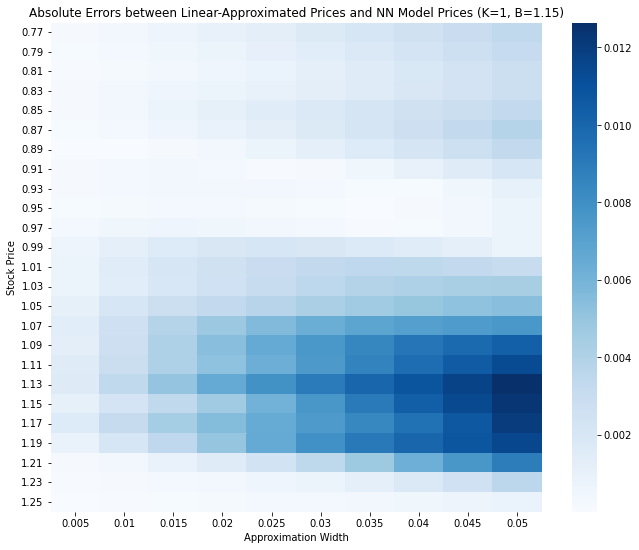

In [22]:
import matplotlib.pyplot as plt
import seaborn as sb
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(df, cmap='Blues')
plt.title('Absolute Errors between Linear-Approximated Prices and NN Model Prices (K=1, B=1.15)')
plt.xlabel('Approximation Width')
plt.ylabel('Stock Price')
plt.show()